# Poissons Equation


Welcome to this FEniCS tutorial, where we will explore how to verify the accuracy of a Poisson's equation solver using the "manufactured solution" technique. FEniCS is a powerful open-source finite element library for solving partial differential equations (PDEs), widely used for scientific computing and simulation.

The "manufactured solution" approach is a valuable method to validate the correctness of finite element implementations. In this technique, we first construct an exact solution to the PDE, often a smooth and analytically known function, that satisfies the given equation. Next, we compute the corresponding right-hand side of the PDE using the exact solution. By feeding the manufactured solution and the derived right-hand side into our FEniCS solver, we can compare the numerical solution with the exact solution, thus quantifying the solver's accuracy.

In this tutorial, we will focus on solving the one-dimensional Poisson's equation:

$$\begin{split}- \nabla^{2} u &= f \quad {\rm in} \ \Omega, \\
             u &= 0 \quad {\rm on} \ \Gamma_{D}, \\
             \nabla u \cdot n &= g \quad {\rm on} \ \Gamma_{N}. \\\end{split}
$$

subject to homogeneous Dirichlet boundary conditions, where u(x) is the unknown function, and f(x) is the right-hand side. We will construct a simple manufactured solution, u_exact(x), and calculate the corresponding f(x) that satisfies the equation.

Throughout the tutorial, we will cover the following steps:

- Importing the necessary modules.
- Defining the manufactured solution and its corresponding right-hand side.
- Creating the one-dimensional mesh using FEniCS.
- Defining the appropriate FunctionSpace for the problem.
- Imposing the homogeneous Dirichlet boundary conditions.
- Formulating the variational problem using FEniCS's TrialFunction and TestFunction.
- Solving the Poisson's equation using FEniCS's solve function.
- Comparing the numerical solution with the exact solution to quantify the solver's accuracy.

By the end of this tutorial, you will have a better understanding of the manufactured solution technique, its importance in validating finite element solvers, and how to implement it using FEniCS on an interval mesh. So, let's get started with our journey into the world - of FEniCS and manufactured solutions!


## Step 1: Import the necessary modules


In [12]:
from fenics import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Step 2: Define the mesh

In [13]:
# Create the mesh
num_elements = 3
# num_elements equally spaced intervals in [0, 1]
mesh = IntervalMesh(num_elements, 0, 1)

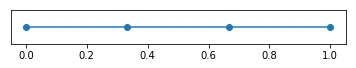

In [14]:
plot(mesh)

## Step 3: Define the function space

The line of code `U = FunctionSpace(mesh, "CG", 1)` in FEniCS creates a function space `U` based on linear continuous elements (`CG`) defined on the mesh with degree `1` polynomial approximation. 

In [15]:
U = FunctionSpace(mesh, "CG", 1)

## Step 4: Define boundary condition

We create a `DirichletBC` object (`bc`) that associates the function space `U` with the boundary condition `u_D` and the subdomain `boundary`. This means that the solution function `u_sol` will have the value `0.0` on the boundary of the domain during the solution of the PDE
.

In [16]:
u_D = Constant(0.0)
boundary = CompiledSubDomain("on_boundary")
bc = DirichletBC(U, u_D, boundary)

## Step 5: Define weak form

$$a(u, v) = L(v) \quad \forall \ v \in V,$$
$$\begin{split}a(u, v) &= \int_{\Omega} \nabla u \cdot \nabla v \, {\rm d} x, \\
L(v)    &= \int_{\Omega} f v \, {\rm d} x.\end{split}$$

In [17]:
u = TrialFunction(U)
v = TestFunction(U)
a = inner(grad(u), grad(v)) * dx

## Step 5.1: Define the manufactured rhs

For this tutorial, let's choose a simple manufactured solution. We will solve the Poisson's equation in 1D:

$$-\Delta u(x) = f(x), 0 < x < 1,$$

where u(x) is the unknown function, and f(x) is the right-hand side. We will choose an analytical solution u_exact(x) that satisfies the above equation.

For this example, let's take:

$$u_{exact}(x) = sin(\pi x)$$

and calculate the corresponding f(x):

$$f(x) = -\Delta u_{exact}(x) = \pi^2  sin(\pi x)$$


In [18]:
f_expr = Expression("pi*pi*sin(pi*x[0])", pi=np.pi, degree=2)

### Visualize Expression 
In the given code snippet:

1. `V = FunctionSpace(mesh, 'CG', 1)`: We create a function space `V` defined on the provided mesh. The function space is based on continuous Galerkin (CG) elements and uses a polynomial degree of 1 for the basis functions. This means that functions in `V` will be represented as piecewise linear continuous functions over each element of the mesh.

2. `f_val = project(f_expr, V)`: We use the `project` function to interpolate the expression `f_expr` onto the function space `V`. This creates a new function `f_val` that represents the projection of the expression `f_expr` onto the space `V`. The `project` function is useful when we want to create functions from `Expression` and visualize them.


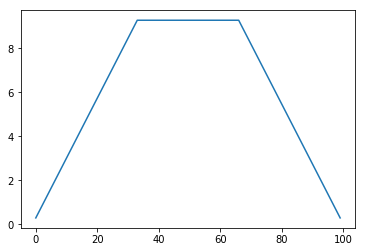

In [19]:
V = FunctionSpace(mesh, 'CG', 1)
f_val = project(f_expr, V)
plt.plot([f_val(x) for x in np.linspace(0,1,100)])

In [20]:
L = f_expr * v * dx

## Compute the solution


In [21]:
u_sol = Function(U)
solve(a == L, u_sol, bc)

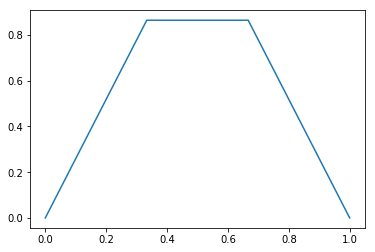

In [22]:
plot(u_sol)

## Post processing

In [23]:
# Define the manufactured solution and its derivative
def u_exact(x):
    return np.sin(np.pi * x)


def f(x):
    return np.pi**2 * np.sin(np.pi * x)

In [24]:
points = np.linspace(0, 1, 100)

# Evaluate the exact solution at the mesh points
u_exact_values = np.array([u_exact(x) for x in points])

# Evaluate the numerical solution at the mesh points
u_numerical_values = np.array([u_sol(x) for x in points])

# Compute the error
error = u_exact_values - u_numerical_values

print("L2 error:", np.linalg.norm(error))

L2 error: 0.6951127497810745


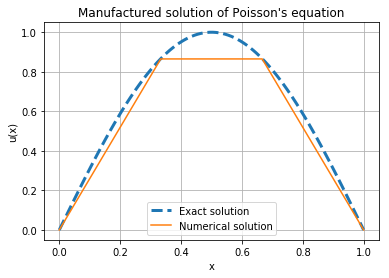

In [25]:
plt.figure()
plt.plot(points, u_exact_values, "--", label='Exact solution', linewidth=3)
plt.plot(points, u_numerical_values, label='Numerical solution')
plt.xlabel('x')
plt.ylabel('u(x)')
plt.legend()
plt.title('Manufactured solution of Poisson\'s equation')
plt.grid()
plt.show()

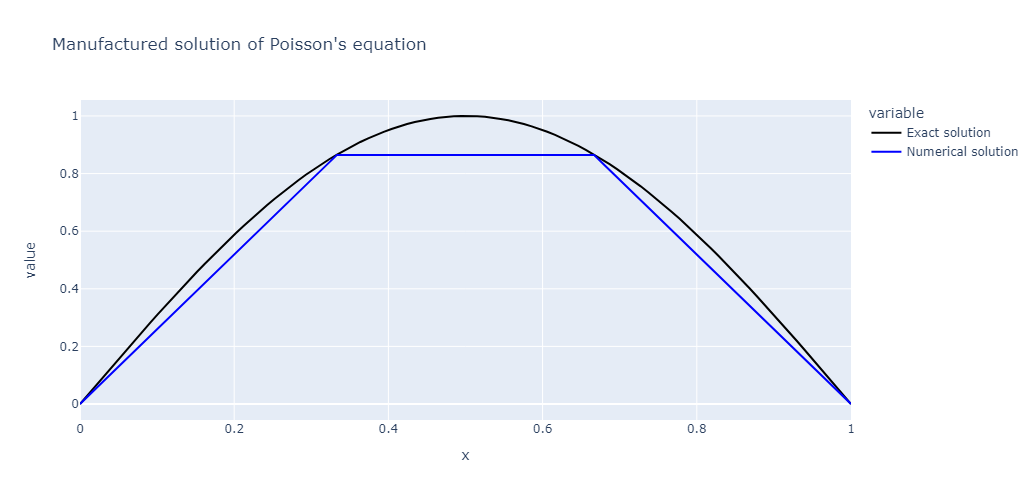

In [26]:
import plotly.express as px

# Convert mesh coordinates and solutions to DataFrame for Plotly Express
import pandas as pd
data = pd.DataFrame({'x': points,
                     'Exact solution': [u_exact(x) for x in points],
                     'Numerical solution': [u_sol(x) for x in points]})

# Create a Plotly Express figure with colors specified
fig = px.line(data, x='x', y=['Exact solution', 'Numerical solution'], title='Manufactured solution of Poisson\'s equation',
              color_discrete_map={'Exact solution': 'black', 'Numerical solution': 'blue'})

fig.update_traces(mode="lines", hovertemplate=None)

# Set the figure size to achieve a 1:1 aspect ratio
fig.update_layout(
    hovermode='x',
    autosize=False,
    width=1000,  # You can adjust this value to get the desired aspect ratio
    height=500
)

# Show the Plotly Express figure
fig.show()